# PurposeL
- Checking the results

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from importlib import reload
import datetime
from glob import glob
import json

import sys
sys.path.append(r'C:\Users\jinho.kim\Github\lamf_analysis_lims\gene_panel_selection\mfishtoolspy')
import mfishtools


In [3]:
# paths to the data
data_folder = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\data\mouse_VISp_gene_expression_matrices_2018-06-14')
output_folder = Path(r'\\allen\programs\mindscope\workgroups\learning\jinho\gene_panel_selection\results')

In [6]:
# load and pre-process data (takes about 1 min)

# read annotation
annotation = pd.read_feather(data_folder / 'anno.feather')
# read data
# TODO: check where this data is coming from. Values are similar to cpm but not exactly the same
cpm_data = pd.read_feather(data_folder / 'exon_cpm.feather')
tpm_data = pd.read_feather(data_folder / 'exon_tpm.feather')

annotation.set_index('sample_id', inplace=True, drop=True)
# data.set_index('gene', inplace=True, drop=True) # only necessary with data_t.feather

# preprocessing
# Removing 'X" in column? from Hannah's code. Don't know when this happens, but leave them here just in case.
if 'X' in cpm_data.columns:
    print('Dropping "X" column from data')
    cpm_data = cpm_data.drop(columns=['X'])
if 'X' in tpm_data.columns:
    print('Dropping "X" column from data')
    tpm_data = tpm_data.drop(columns=['X']) 
if 'X' in annotation.columns:
    print('Dropping "X" column fro annotation')
    annotation = annotation.drop(columns=['X'])

# change the row order of annotation to match the order of columns in data
# annotation = annotation.loc[data.columns]  # don't need this, but add assert statement to check
assert np.all(annotation.index.values == tpm_data.columns.values)
assert np.all(annotation.index.values == cpm_data.columns.values)

# data conversion to log2
tpm_log2 = np.log2(tpm_data + 1)
cpm_log2 = np.log2(cpm_data + 1)

# read supertype information
# TODO: re-define supertype (will be addressed in another notebook)
supertype_folder = Path('//allen/programs/mindscope/workgroups/omfish/hannahs/mfish_project/gene_panels')
supertype_fn = supertype_folder / 'tasic2018_supertypes_manual_v2.xlsx'
sheet_name = 'all_supertypes_v2'
supertype = pd.read_excel(supertype_fn, sheet_name=sheet_name)
supertype.rename(columns={'Cell Type': 'cell_type', 'Supertype': 'supertype'}, inplace=True)
supertype.cell_type = supertype.cell_type.str.replace('\xa0', ' ')
supertype.supertype = supertype.supertype.str.replace('\xa0', ' ')
assert np.all([ct in annotation['cluster_label'].values for ct in supertype.cell_type.values])
supertype.set_index('cell_type', inplace=True, drop=True)

annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_41244\1359400274.py:46: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation['supertype_label'] = annotation.cluster_label.map(supertype.supertype)


In [30]:
# loading the results
ops_fn_list = list(output_folder.glob('ops_*.json'))
ops_fn_gabaergic = []
ops_gabaergic = []
results_gabaergic = []
for ops_fn in ops_fn_list:
    with open(ops_fn, 'r') as f:
        ops = json.load(f)
    if 'GABAergic' in ops['panel_name']:
        ops_fn_gabaergic.append(ops_fn)
        ops_gabaergic.append(ops)
        results_fn = ops_fn.name.replace('ops', 'results')
        with open(output_folder / results_fn, 'r') as f:
            results_gabaergic.append(json.load(f))
print(len(results_gabaergic))    

4


In [9]:
result_i = 0
results = results_gabaergic[result_i]
ops = ops_gabaergic[result_i]
print(results.keys())


dict_keys(['run_genes', 'built_panel', 'metric'])


## Compare gene panels

In [31]:
built_panel_df = pd.DataFrame()
for i in range(len(results_gabaergic)):
    results = results_gabaergic[i]
    ops = ops_gabaergic[i]
    panel_name = ops['panel_name']
    built_panel_pre = results['built_panel']
    starting_genes = ops['starting_genes']
    built_panel = [gene for gene in built_panel_pre if gene not in starting_genes]
    metric = results['metric']
    
    built_panel_df = pd.concat([built_panel_df, 
                              pd.DataFrame({'panel_name': panel_name, 
                                        'starting_gene': [starting_genes],
                                        'built_panel': [built_panel],
                                        'metric': [metric],
                                        'GABAergic_group_level': ops['GABAergic_group_level'],
                                        'GABAergic_mapping_level': ops['GABAergic_mapping_level'],
                                        'Glutamatergic_group_level': ops['Glutamatergic_group_level'],
                                        'Glutamatergic_mapping_level': ops['Glutamatergic_mapping_level'],
                                        'GABAergic_other_group_level': ops['GABAergic_other_group_level'],
                                        'GABAergic_other_mapping_level': ops['GABAergic_other_mapping_level'],
                                        'Glutamatergic_other_group_level': ops['Glutamatergic_other_group_level'],
                                        'Glutamatergic_other_mapping_level': ops['Glutamatergic_other_mapping_level'],})
                                        ])
built_panel_df.reset_index(drop=True, inplace=True)

In [32]:
built_panel_df

,panel_name,starting_gene,built_panel,metric,GABAergic_group_level,GABAergic_mapping_level,Glutamatergic_group_level,Glutamatergic_mapping_level,GABAergic_other_group_level,GABAergic_other_mapping_level,Glutamatergic_other_group_level,Glutamatergic_other_mapping_level
0,GABAergic,"[Gad2, Slc17a7, Pvalb, Sst, Vip, Cck, Tac1, Np...","[Cxcl14, Cplx3, Zbtb20, Hopx, Cd24a, Shisa8, S...","[0.14866077728162674, 0.1340319594145109, 0.12...",cluster,cluster,subclass,subclass,class,cluster,class,subclass
1,GABAergic,"[Gad2, Slc17a7, Pvalb, Sst, Vip, Cck, Tac1, Np...","[Cxcl14, Cplx3, Zbtb20, Hopx, Cd24a, Shisa8, P...","[0.14748043661170993, 0.13410163896933247, 0.1...",cluster,cluster,subclass,subclass,class,cluster,class,subclass
2,GABAergic,"[Gad2, Slc17a7, Pvalb, Sst, Vip, Cck, Tac1, Np...","[Luzp2, Parm1, Cd24a, Cadps2, Igfbp4, Ppapdc1a...","[0.1316714336002628, 0.11954245646682259, 0.10...",cluster,cluster,subclass,subclass,subclass,subclass,class,class
3,GABAergic,"[Gad2, Slc17a7, Pvalb, Sst, Vip, Cck, Tac1, Np...","[Luzp2, Parm1, Cd24a, Cadps2, Igfbp4, Ppapdc1a...","[0.13185026639417466, 0.11896035159361043, 0.1...",cluster,cluster,subclass,subclass,subclass,subclass,class,class


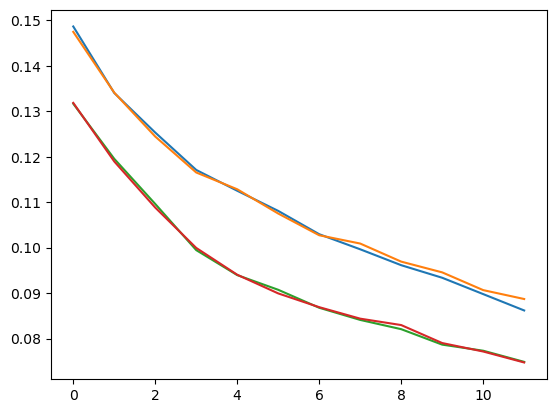

In [33]:
fig, ax = plt.subplots()
for i, row in built_panel_df.iterrows():
    ax.plot(row['metric'])

In [34]:
# take 'built_panel' column from built_panel_df and expand the list to each column in the dataframe
# this will be the final gene panel
gene_panel = pd.DataFrame(built_panel_df['built_panel'].values.tolist(), index=built_panel_df.index)
gene_panel.columns = [f'gene_{i}' for i in gene_panel.columns]
gene_panel


,gene_0,gene_1,gene_2,gene_3,gene_4,gene_5,gene_6,gene_7,gene_8,gene_9,gene_10,gene_11
0,Cxcl14,Cplx3,Zbtb20,Hopx,Cd24a,Shisa8,Sema3e,Lin7a,Thsd7a,Igfbp4,Lypd6,Isoc1
1,Cxcl14,Cplx3,Zbtb20,Hopx,Cd24a,Shisa8,Plxdc2,Sema3e,Reln,Popdc3,Caln1,Ramp1
2,Luzp2,Parm1,Cd24a,Cadps2,Igfbp4,Ppapdc1a,Kcns3,Rgs12,Cbln2,Shisa8,Lypd6,Nefl
3,Luzp2,Parm1,Cd24a,Cadps2,Igfbp4,Ppapdc1a,Kcns3,Rgs12,Cbln2,Shisa8,Lypd6,Nefl


In [35]:
ind = 2
ops = ops_gabaergic[ind]

# filtering and assigning group_label
# Group means target clustering that I want to classify eventually
# There is also mapping_label, to which I want to match first before calculating classification accuracy
# E.g., match individual samples to cluster level but then classify them at supertype level
# E.g., classification can happen in mixed level, some at the cluster level while others in subclass level

# If "other" group and mapping levels are different from group and mapping levels
# then assign relevant labels to "other" group and mapping levels
#   "other" is relevant only when filtering by the layers
#   It means the rest of groups of mappings that can be within the imaging regime but we want to exclude from further analysis

# Filtering based on layer abundance
# TODO: test thresholds. 
# TODO: Better to do this from merFISH data

keep_groups = []
keep_mappings = []
other_groups = []
other_mappings = []

if 'Glutamatergic' in ops['keep_class']:
    # Assign group and mapping labels
    group_level_label = f'{ops["Glutamatergic_group_level"]}_label'
    group_label_list = [f'Glutamatergic {gl}' for gl in annotation.loc[annotation.class_label == 'Glutamatergic', group_level_label]] # To disambiguate from GABAergic groups
    annotation.loc[annotation.class_label == 'Glutamatergic', 'group_label'] = group_label_list
    mapping_level_label = f'{ops["Glutamatergic_mapping_level"]}_label'
    mapping_label_list = [f'Glutamatergic {ml}' for ml in annotation.loc[annotation.class_label == 'Glutamatergic', mapping_label]] # To disambiguate from GABAergic mappings
    annotation.loc[annotation.class_label == 'Glutamatergic', 'mapping_label'] = mapping_label_list
    
    # Assign keep and other groups.
    # If lower than class level, then consider layer filtering (L1234 only for now)
    if ops['Glutamatergic_group_level'] == 'class':
        keep_groups += ['Glutamatergic']
    else:
        temp_annotation = annotation.query('class_label=="Glutamatergic"')
        if ops['layer_1234_filter']:
            keep_groups += [gl for gl in temp_annotation['group_label'].unique().tolist() if gl.split(' ')[1] in ['L2/3', 'L4']] # Have class label at the beginning
            # Process "other" groups
            other_group_level_label = f'{ops["Glutamatergic_other_group_level"]}_label'
            temp_other_groups = [gl for gl in temp_annotation['group_label'].unique().tolist() if gl.split(' ')[1] in ['L5', 'NP']] # Have class label at the beginning
            if other_group_level_label == group_level_label: # no need to change group labels
                other_groups += temp_other_groups
            else:
                # Add L5 after class label
                other_group_labels = [f'Glutamatergic L5 {gl}' for gl in annotation[annotation['group_label'].isin(temp_other_groups)][other_group_level_label].values]
                annotation.loc[annotation['group_label'].isin(temp_other_groups), 'group_label'] = other_group_labels
                other_groups += np.unique(other_group_labels).tolist()
        else:
            keep_groups += temp_annotation['group_label'].unique().tolist()
    # Assign keep and other mappings.
    if ops['Glutamatergic_mapping_level'] == 'class':
        keep_mappings += ['Glutamatergic']
    else:
        temp_annotation = annotation.query('class_label=="Glutamatergic"')
        if ops['layer_1234_filter']:
            keep_mappings += [ml for ml in temp_annotation['mapping_label'].unique().tolist() if ml.split(' ')[1] in ['L2/3', 'L4']] # Have class label at the beginning
            # Process "other" groups
            other_mapping_level_label = f'{ops["Glutamatergic_other_mapping_level"]}_label'
            temp_other_mappings = [ml for ml in temp_annotation['mapping_label'].unique().tolist() if ml.split(' ')[1] in ['L5', 'NP']] # Have class label at the beginning
            if other_mapping_level_label == mapping_level_label: # no need to change mapping labels
                other_mappings += temp_other_mappings
            else:
                # Add L5 after class label
                other_mapping_labels = [f'Glutamatergic L5 {ml}' for ml in annotation[annotation['mapping_label'].isin(temp_other_mappings)][other_mapping_level_label].values]
                annotation.loc[annotation['mapping_label'].isin(temp_other_mappings), 'mapping_label'] = other_mapping_labels
                other_mappings += np.unique(other_mapping_labels).tolist()
        else:
            keep_mappings += temp_annotation['mapping_label'].unique().tolist()

# Same for GABAergic
# Except for filtering, now we are using scRNAseq layer-enriched data with thresholds
if 'GABAergic' in ops['keep_class']:
    # Assign group and mapping labels
    group_level_label = f'{ops["GABAergic_group_level"]}_label'
    group_label_list = [f'GABAergic {gl}' for gl in annotation.loc[annotation.class_label == 'GABAergic', group_level_label]] # To disambiguate from Glutamatergic groups
    annotation.loc[annotation.class_label == 'GABAergic', 'group_label'] = group_label_list
    mapping_level_label = f'{ops["GABAergic_mapping_level"]}_label'
    mapping_label_list = [f'GABAergic {ml}' for ml in annotation.loc[annotation.class_label == 'GABAergic', mapping_level_label]] # To disambiguate from Glutamatergic mappings
    annotation.loc[annotation.class_label == 'GABAergic', 'mapping_label'] = mapping_label_list
    
    # Assign keep and other groups.
    # If lower than class level, then consider layer filtering (L1234 only for now)
    # Also need to name them different (adding L5 in front of the group and mapping labels)
    if ops['GABAergic_group_level'] == 'class':
        keep_groups += ['GABAergic']
    else:
        temp_annotation = annotation.query('class_label=="GABAergic"')
        if ops['layer_1234_filter']:
            # Filtering process based on the layer abundance
            layer_df = annotation.query('class_label=="GABAergic"')[['layer_label', 'cluster_label']].copy()
            layer_table = layer_df.groupby(['layer_label', 'cluster_label']).size().unstack(fill_value=0)
            prop_table = layer_table.div(layer_table.sum(axis=0), axis=1)
            L1234_prop_sum = prop_table.loc[ops['L1234_labels']].sum(axis=0)
            L1234_inh_types = set(L1234_prop_sum[L1234_prop_sum >= ops['L1234_layer_threshold']].index.values)
            not_L1234_inh_types = set(layer_df.cluster_label).difference(L1234_inh_types)
            L6_prop_sum = prop_table.loc[ops['L6_labels']].sum(axis=0)
            L6_inh_types = set(L6_prop_sum[L6_prop_sum >= ops['L6_layer_threshold']].index.values)
            L5_inh_types = not_L1234_inh_types.difference(L6_inh_types)
            # L1234_inh_types are going to be kept
            # L5_inh_types are going to be "other"
            # Ignore L6_inh_types (assume they won't be imaged)
            keep_annotation = temp_annotation[temp_annotation['cluster_label'].isin(L1234_inh_types)]
            other_annotation = temp_annotation[temp_annotation['cluster_label'].isin(L5_inh_types)]
            
            keep_groups += keep_annotation['group_label'].unique().tolist()

            # Process "other" groups
            other_group_level_label = f'{ops["GABAergic_other_group_level"]}_label'
            temp_other_groups = other_annotation['group_label'].unique().tolist()
            if other_group_level_label == group_level_label: # no need to change group labels
                other_groups += temp_other_groups
            else:
                # Add L5 after class label
                other_group_labels = [f'GABAergic L5 {gl}' for gl in annotation[annotation['group_label'].isin(temp_other_groups)][other_group_level_label].values]
                annotation.loc[annotation['group_label'].isin(temp_other_groups), 'group_label'] = other_group_labels
                other_groups += np.unique(other_group_labels).tolist()
        else:
            keep_groups += temp_annotation['group_label'].unique().tolist()
    # Assign keep and other mappings.
    if ops['GABAergic_mapping_level'] == 'class':
        keep_mappings += ['GABAergic']
    else:
        temp_annotation = annotation.query('class_label=="GABAergic"')
        if ops['layer_1234_filter']:
            # Filtering process should have been done already in the above if clause
            # keep_annotation and other_annotation are already defined
            keep_mappings += keep_annotation['mapping_label'].unique().tolist()
            
            # Process "other" groups
            other_mapping_level_label = f'{ops["GABAergic_other_mapping_level"]}_label'
            temp_other_mappings = other_annotation['mapping_label'].unique().tolist()
            if other_mapping_level_label == mapping_level_label: # no need to change mapping labels
                other_mappings += temp_other_mappings
            else:
                # Add L5 after class label
                other_mapping_labels = [f'GABAergic L5 {ml}' for ml in annotation[annotation['mapping_label'].isin(temp_other_mappings)][other_mapping_level_label].values]
                annotation.loc[annotation['mapping_label'].isin(temp_other_mappings), 'mapping_label'] = other_mapping_labels
                other_mappings += np.unique(other_mapping_labels).tolist()
        else:
            keep_mappings += temp_annotation['mapping_label'].unique().tolist()

# assign cluster to nan mapping labels
# for filtering using "off clusters" information (e.g., glial cells)
annotation.loc[annotation['mapping_label']=='nan', 'mapping_label'] = annotation.loc[annotation['mapping_label']=='nan', 'cluster_label'] 

C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_41244\235234473.py:79: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation.loc[annotation.class_label == 'GABAergic', 'group_label'] = group_label_list
C:\Users\jinho.kim\AppData\Local\Temp\ipykernel_41244\235234473.py:82: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  annotation.loc[annotation.class_label == 'GABAergic', 'mapping_label'] = mapping_label_list


In [37]:
# check the annotation process with results
assert ops['keep_mappings'] == keep_mappings
assert ops['keep_groups'] == keep_groups
assert ops['other_mappings'] == other_mappings
assert ops['other_groups'] == other_groups

In [38]:

# calculate proportions and medians for mapping labels and for group labels
expr_thresh = 1
# make data_log2 to have another level of columns with matching cluster names per cell ID
tpm_log2_cluster = tpm_log2.copy().T
gene_column_names = list(tpm_log2_cluster.columns)
assert np.all(tpm_log2.columns == annotation.index.values)
# groupby cluster and calculate median and proportion
tpm_log2_cluster['mapping_label'] = annotation['mapping_label']
tpm_log2_cluster['group_label'] = annotation['group_label']
tpm_median_per_mapping = tpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').median().T
tpm_prop_expr_mapping = tpm_log2_cluster[gene_column_names + ['mapping_label']].groupby('mapping_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
tpm_median_per_group = tpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').median().T
tpm_prop_expr_group = tpm_log2_cluster[gene_column_names + ['group_label']].groupby('group_label').apply(lambda x: (x > expr_thresh).mean(axis=0)).T
assert np.all(tpm_prop_expr_mapping.index.values == tpm_median_per_mapping.index.values)
assert np.all(tpm_prop_expr_group.index.values == tpm_median_per_group.index.values)
assert np.all(tpm_prop_expr_mapping.index.values == tpm_log2.index.values)
assert np.all(tpm_prop_expr_group.index.values == tpm_log2.index.values)

In [85]:
keep_mappings

['GABAergic Pvalb Tpbg',
 'GABAergic Vip Chat Htr1f',
 'GABAergic Lamp5 Lsp1',
 'GABAergic Sst Hpse Sema3c',
 'GABAergic Vip Pygm C1ql1',
 'GABAergic Vip Ptprt Pkp2',
 'GABAergic Vip Igfbp4 Mab21l1',
 'GABAergic Sst Chodl',
 'GABAergic Lamp5 Ntn1 Npy2r',
 'GABAergic Vip Igfbp6 Car10',
 'GABAergic Vip Crispld2 Kcne4',
 'GABAergic Vip Igfbp6 Pltp',
 'GABAergic Pvalb Reln Itm2a',
 'GABAergic Vip Lmo1 Myl1',
 'GABAergic Vip Crispld2 Htr2c',
 'GABAergic Lamp5 Plch2 Dock5',
 'GABAergic Vip Col15a1 Pde1a',
 'GABAergic Vip Rspo4 Rxfp1 Chat',
 'GABAergic Lamp5 Fam19a1 Tmem182',
 'GABAergic Lamp5 Fam19a1 Pax6',
 'GABAergic Vip Arhgap36 Hmcn1',
 'GABAergic Sncg Vip Itih5',
 'GABAergic Lamp5 Lhx6',
 'GABAergic Sncg Slc17a8',
 'GABAergic Sncg Vip Nptx2',
 'GABAergic Pvalb Vipr2',
 'GABAergic Lamp5 Krt73',
 'GABAergic Serpinf1 Aqp5 Vip',
 'GABAergic Sst Calb2 Pdlim5',
 'GABAergic Sst Mme Fam114a1',
 'GABAergic Sst Hpse Cbln4',
 'GABAergic Vip Lect1 Oxtr',
 'GABAergic Sst Tac1 Htr1d',
 'GABAergic Snc

In [96]:
row = built_panel_df.iloc[ind]
run_genes = row.starting_gene + row.built_panel
run_mappings = keep_mappings + other_mappings
keep_samples = annotation[annotation['mapping_label'].isin(run_mappings)].index.values

map_data = tpm_log2.loc[row.starting_gene + row.built_panel, keep_samples]
mapping_median_data = tpm_median_per_mapping.loc[run_genes, run_mappings]
cluster_call = annotation.loc[keep_samples, 'mapping_label']

corr_matrix_df = mfishtools.cor_tree_mapping(map_data,
median_data=mapping_median_data,
genes_to_map=run_genes)

[ 0.          0.          3.54598177  8.30157415 12.09610605 14.13421707
 23.1980116  26.28003314 39.90057995 43.86081193 47.35708368 50.32311516
 52.16238608 52.42750621 53.17315659 57.56420878 58.26014913 60.31483016
 62.004971   64.07622204 64.42419221 64.2087821  65.50124275 66.94283347
 67.22452361 67.6056338  68.05302403 69.95857498]


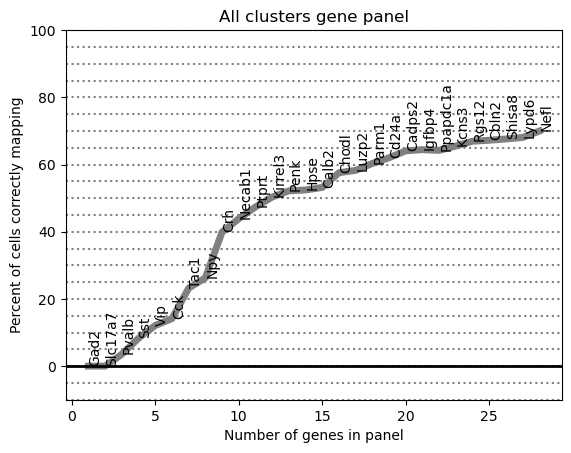

In [67]:
reload(mfishtools)
fig, ax = plt.subplots()
frac, ax = mfishtools.fraction_correct_with_genes(run_genes, map_data, mapping_median_data,
cluster_call=cluster_call, ax=ax)
print(frac)

Text(0.5, 1.0, 'New panel')

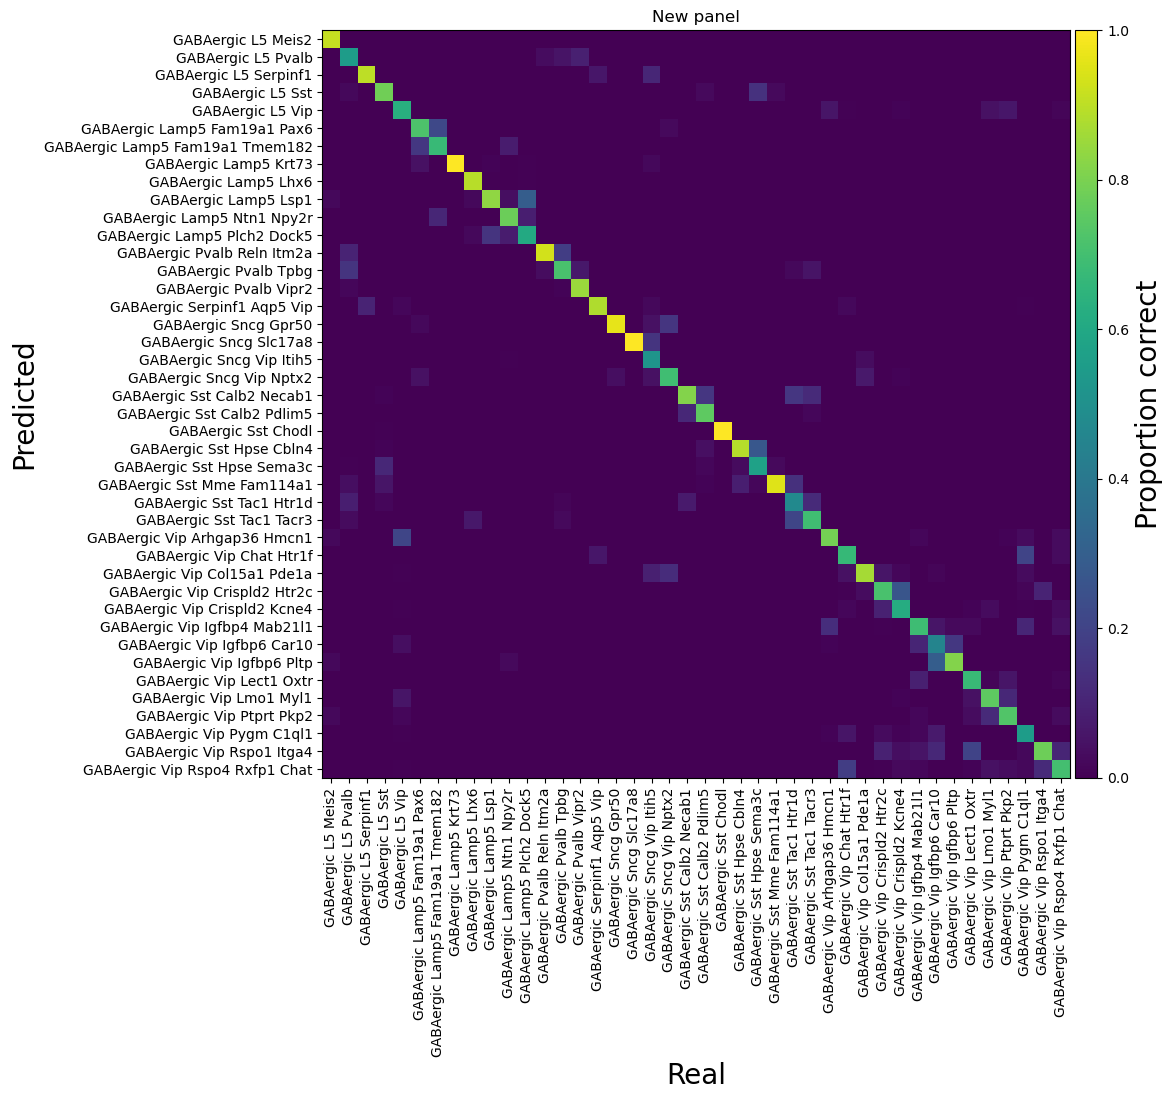

In [94]:
ranked_leaf_and_value = mfishtools.get_top_match(corr_matrix_df, replace_na_with='None')
top_leaf = ranked_leaf_and_value['top_leaf'].values
new_confusion = mfishtools.get_confusion_matrix(cluster_call.loc[corr_matrix_df.index].values, top_leaf)

ax = mfishtools.plot_confusion_matrix(new_confusion)
ax.set_title('New panel')

## Hannah's previous results

In [52]:
hanna_temp.values

array([['Ngf', 'Coro6', 'Tpbg', 'Sstr1', 'Krt12', 'Grm8', 'Oprm1',
        'Sstr2', 'Slc18a3', 'Chrna5', 'St6galnac5', 'Moxd1'],
       ['Tcerg1l', 'Pcdh20', 'Htr2c', 'Trpc4', 'Mmp17', 'Enc1', 'Hcrtr2',
        'Gabra5', 'Nog', 'Ngf', 'Ldb2', 'Krt12']], dtype=object)

In [54]:
np.array(row_one_values)

array(['Pld5', 'Tcerg1l', 'Htr2c', 'Pcdh20', 'Oxtr', 'Popdc3', 'Ndst3',
       'Trhde', 'Cdh6', 'Hs3st2', 'Hcrtr2', 'Syndig1l'], dtype=object)

In [59]:
np.vstack((row_one_values, hanna_temp.values))

array([['Pld5', 'Tcerg1l', 'Htr2c', 'Pcdh20', 'Oxtr', 'Popdc3', 'Ndst3',
        'Trhde', 'Cdh6', 'Hs3st2', 'Hcrtr2', 'Syndig1l'],
       ['Ngf', 'Coro6', 'Tpbg', 'Sstr1', 'Krt12', 'Grm8', 'Oprm1',
        'Sstr2', 'Slc18a3', 'Chrna5', 'St6galnac5', 'Moxd1'],
       ['Tcerg1l', 'Pcdh20', 'Htr2c', 'Trpc4', 'Mmp17', 'Enc1', 'Hcrtr2',
        'Gabra5', 'Nog', 'Ngf', 'Ldb2', 'Krt12']], dtype=object)

In [60]:
hannah_temp = pd.read_csv(output_folder / 'hannah_gabaergic_temp.csv')
columns = range(len(hannah_temp.columns))
row_one_values = np.array(hannah_temp.columns)
hanna_temp_df = pd.DataFrame(np.vstack((row_one_values, hanna_temp.values)), columns=columns)
hanna_temp_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,Pld5,Tcerg1l,Htr2c,Pcdh20,Oxtr,Popdc3,Ndst3,Trhde,Cdh6,Hs3st2,Hcrtr2,Syndig1l
1,Ngf,Coro6,Tpbg,Sstr1,Krt12,Grm8,Oprm1,Sstr2,Slc18a3,Chrna5,St6galnac5,Moxd1
2,Tcerg1l,Pcdh20,Htr2c,Trpc4,Mmp17,Enc1,Hcrtr2,Gabra5,Nog,Ngf,Ldb2,Krt12


[ 0.          0.          3.54598177  8.30157415 12.09610605 14.13421707
 23.1980116  26.28003314 39.90057995 43.86081193 47.35708368 50.32311516
 52.16238608 52.42750621 53.17315659 57.56420878 58.26014913 59.35376968
 60.53024027 60.81193041 61.32560066 62.02154101 62.86661143 63.77796189
 64.04308202 64.25849213 65.41839271 65.43496272]


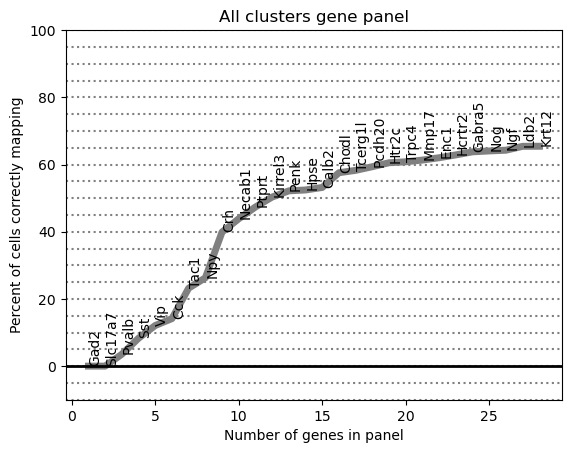

In [107]:
old_ind = 2

row = built_panel_df.iloc[0]
run_genes = row.starting_gene + list(hanna_temp_df.iloc[old_ind].values)
run_mappings = keep_mappings + other_mappings
keep_samples = annotation[annotation['mapping_label'].isin(run_mappings)].index.values

map_data = tpm_log2.loc[run_genes, keep_samples]
mapping_median_data = tpm_median_per_mapping.loc[run_genes, run_mappings]
cluster_call = annotation.loc[keep_samples, 'mapping_label']

fig, ax = plt.subplots()
frac, ax = mfishtools.fraction_correct_with_genes(run_genes, map_data, mapping_median_data,
cluster_call=cluster_call, ax=ax)
print(frac)

Text(0.5, 1.0, 'Old panel')

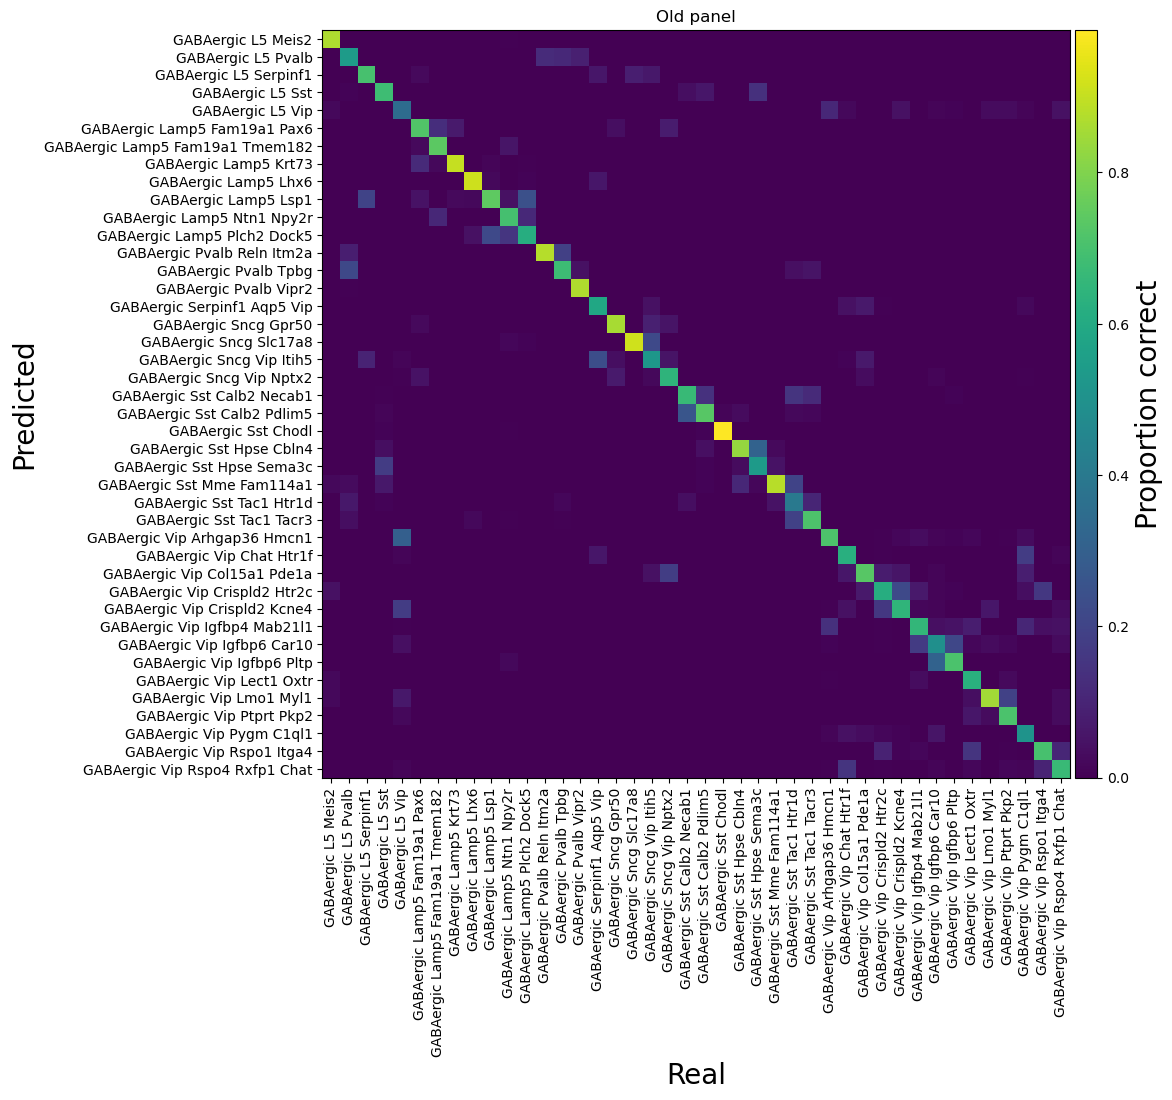

In [108]:
corr_matrix_df = mfishtools.cor_tree_mapping(map_data,
median_data=mapping_median_data,
genes_to_map=run_genes)

ranked_leaf_and_value = mfishtools.get_top_match(corr_matrix_df, replace_na_with='None')
top_leaf = ranked_leaf_and_value['top_leaf'].values
old_confusion = mfishtools.get_confusion_matrix(cluster_call.loc[corr_matrix_df.index].values, top_leaf)

ax = mfishtools.plot_confusion_matrix(old_confusion)
ax.set_title('Old panel')

Text(0.5, 1.0, 'Confusion difference')

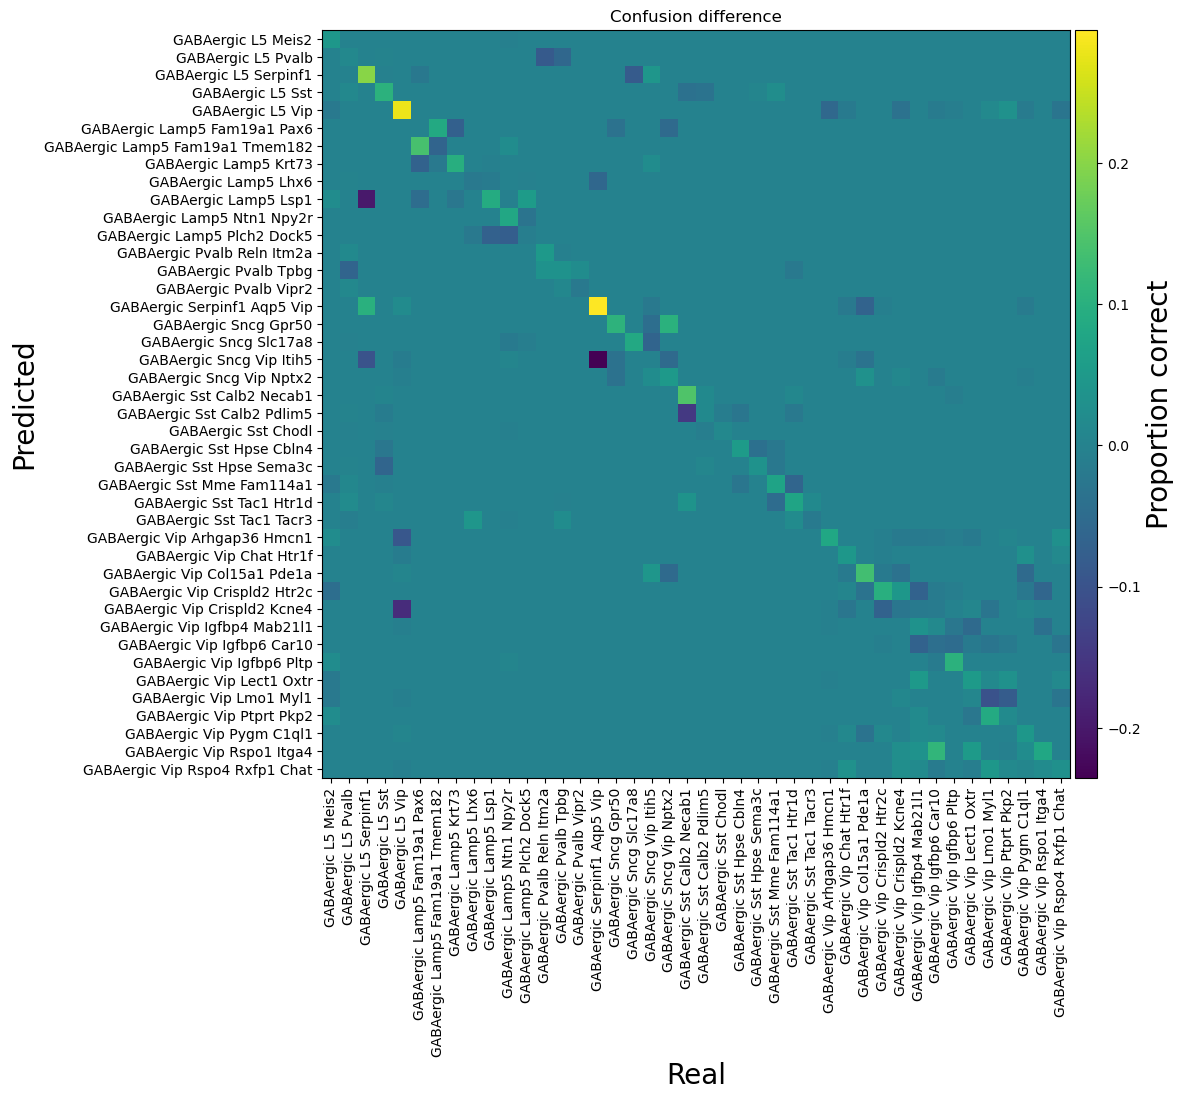

In [109]:
confusion_diff = new_confusion - old_confusion

ax = mfishtools.plot_confusion_matrix(confusion_diff)
ax.set_title('Confusion difference')

## upper bound

In [112]:
result_i = 0
results = results_gabaergic[result_i]
run_genes = results['run_genes']


In [114]:
ops = ops_gabaergic[result_i]
len(ops['starting_genes'])

16

In [113]:
len(run_genes)

510

In [119]:
set(ops['starting_genes']) - set(run_genes)

set()

[ 0.          0.          4.90472245  5.0041425   8.76553438  7.68848384
 12.46064623 17.66362883 17.5973488  20.26512013 26.36288318 27.97017399
 28.86495443 30.25683513 32.44407622 33.86909693 34.73073737 35.36039768
 35.84092792 35.990058   37.97845899 38.49212925 39.58574979 40.46396023
 40.74565037 42.70091135 43.24772162 43.66197183 44.27506214 44.47390224
 45.30240265 45.35211268 46.08119304 46.61143331 46.82684341 47.10853355
 48.58326429 48.69925435 49.21292461 49.69345485 49.7928749  49.5940348
 50.07456504 50.25683513 53.2062966  56.47058824 58.01159901 58.24357912
 58.1938691  59.8011599  59.81772991 60.69594035 61.34217067 61.42502071
 61.14333057 61.25932063 62.38608119 62.43579122 62.58492129 62.86661143
 62.94946147 63.42999171 63.33057167 63.54598177 63.97680199 64.3910522
 65.05385253 65.63380282 65.66694283 66.03148302 67.12510356 67.02568351
 67.05882353 67.04225352 67.07539354 66.95940348 66.97597349 66.9925435
 67.04225352 66.94283347 67.2079536  67.47307374 67.65

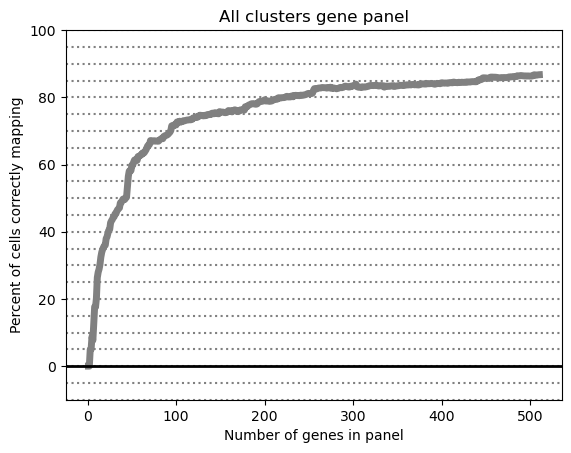

In [121]:
# 1 min with 510 genes. Was taking > 10 min with all the genes
reload(mfishtools)
result_i = 0
results = results_gabaergic[result_i]
run_genes = results['run_genes']

map_data = tpm_log2.loc[run_genes, keep_samples]
mapping_median_data = tpm_median_per_mapping.loc[run_genes, run_mappings]
cluster_call = annotation.loc[keep_samples, 'mapping_label']

fig, ax = plt.subplots()
frac, ax = mfishtools.fraction_correct_with_genes(run_genes, map_data, mapping_median_data,
cluster_call=cluster_call, ax=ax,
add_text=False)
print(frac)

Text(0.5, 1.0, 'Upper bound (all filtered genes + starting genes)')

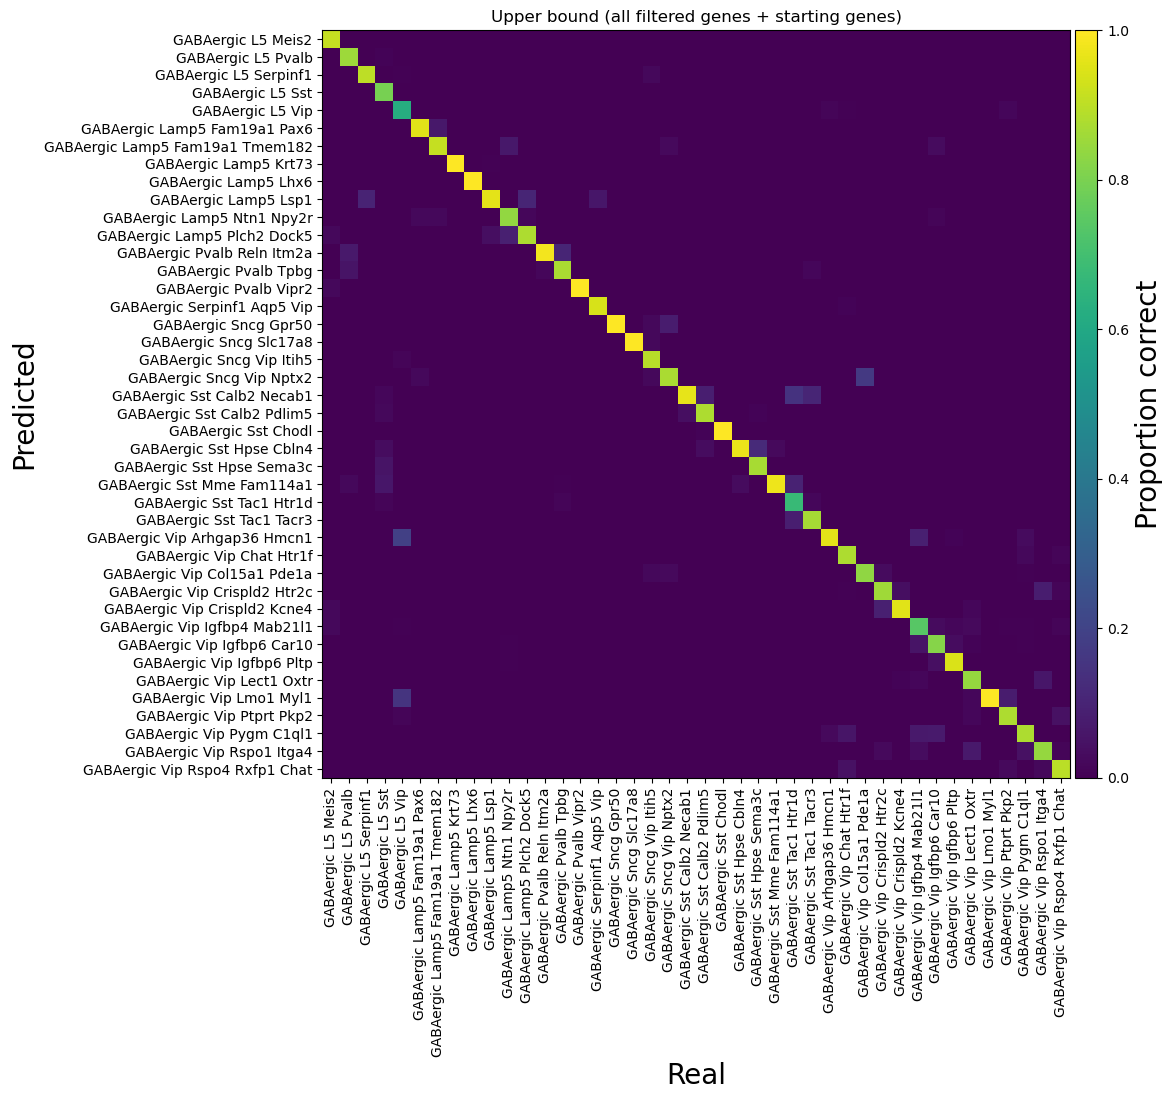

In [123]:
corr_matrix_df = mfishtools.cor_tree_mapping(map_data,
median_data=mapping_median_data,
genes_to_map=run_genes)

ranked_leaf_and_value = mfishtools.get_top_match(corr_matrix_df, replace_na_with='None')
top_leaf = ranked_leaf_and_value['top_leaf'].values
upper_bound_confusion = mfishtools.get_confusion_matrix(cluster_call.loc[corr_matrix_df.index].values, top_leaf)

ax = mfishtools.plot_confusion_matrix(upper_bound_confusion)
ax.set_title('Upper bound (all filtered genes + starting genes)')

Text(0.5, 1.0, 'Confusion difference (upper bound - new)')

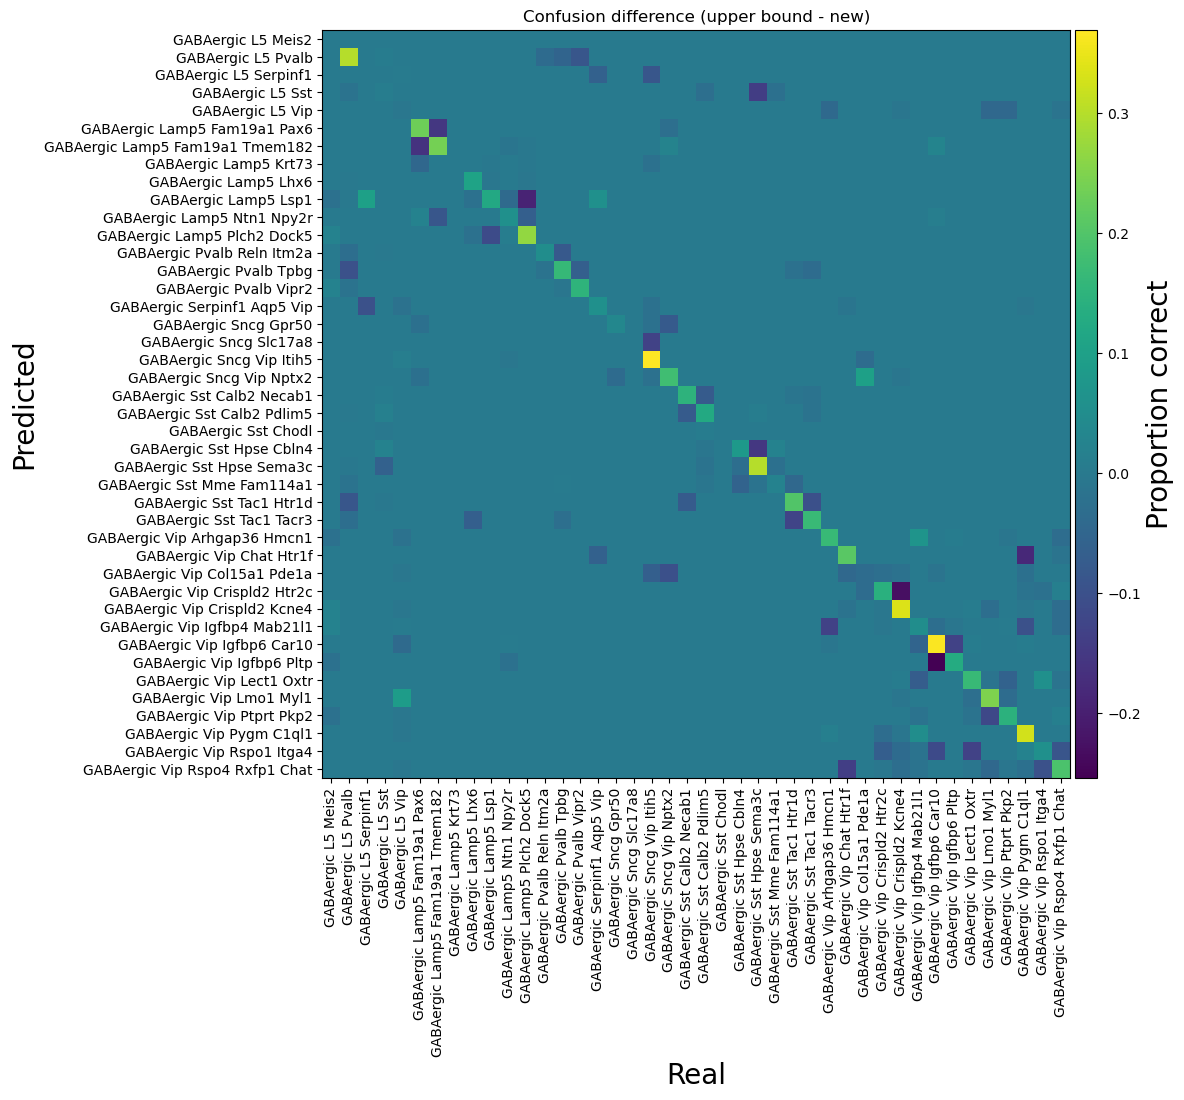

In [124]:
confusion_diff = upper_bound_confusion - new_confusion

ax = mfishtools.plot_confusion_matrix(confusion_diff)
ax.set_title('Confusion difference (upper bound - new)')

In [ ]:
### Is there a correlation with confusion and the number of samples?

In [136]:
confusion_diff_diag_values = np.diag(confusion_diff.values[5:, 5:])

In [134]:
test_labels = list(confusion_diff.index.values[5:])

In [137]:
num_samples = [len(annotation[annotation['mapping_label']==tl]) for tl in test_labels]


Text(0, 0.5, 'Confusion difference')

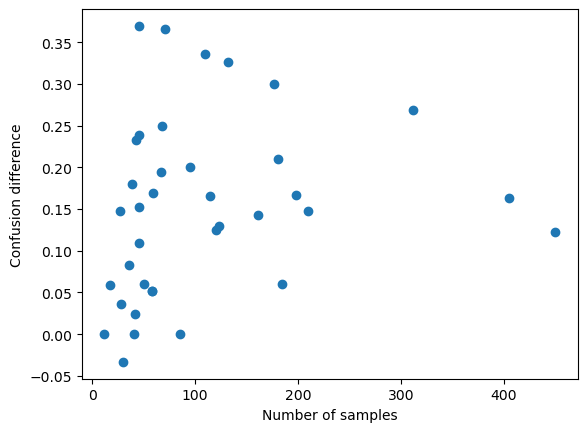

In [139]:
fig, ax = plt.subplots()
ax.scatter(num_samples, confusion_diff_diag_values)
ax.set_xlabel('Number of samples')
ax.set_ylabel('Confusion difference')

## Checking gene expression distribution

In [ ]:
group_label = f'{ops["Glutamatergic_group_level"]}_label'
mapping_label = f'{ops["Glutamatergic_mapping_level"]}_label'
temp_annotation = annotation.query('class_label=="Glutamatergic"')

KeyError: 'mapping_label'

2


dict_keys(['run_genes', 'built_panel', 'metric'])
